This script depicts the design of the Convolutional Neural Netwrok (CNN) employed for musical genre classification. The "genre_classifier.json" file provides the features of the model which are the MFCCs (Mel-Frequency Cepstral Coefficients) of the audio files, it also gives the labels (11 in total, labeled from 0 to 10) and the musical genres (11 in total: Blues, Classical, Country, Disco, Electronic, Hiphop, Jazz, Metal, Pop, Reggae, Rock).

## Import libraries ##

In [3]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

2024-06-27 23:25:16.769650: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:

# Load data from JSON file
def load_data(json_path):
    '''Function to load the data contained in the json file'''
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Extract features, labels and genres
    X = np.array(data['mfcc_features'])
    y = np.array(data['labels'])
    genres = np.array(data['genres'])
    
    return X, y, genres

# Path to the JSON file
json_path = 'genre_classifier.json'

# Load the data
X, y, genres = load_data(json_path)

# Expand dimensions to match CNN input shape requirements
X = np.expand_dims(X, axis=-1)
print(genres)

['Blues' 'Classical' 'Country' 'Disco' 'Electronic' 'Hiphop' 'Jazz'
 'Metal' 'Pop' 'Reggae' 'Rock']


In [5]:
#Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((9764, 130, 13, 1),
 (1221, 130, 13, 1),
 (1221, 130, 13, 1),
 (9764,),
 (1221,),
 (1221,))

## Define function to plot the results

In [6]:
# Plotting the results
def plot_history(history):
    """Function to plot accuracy/loss for training/validation set as a function of the epochs.

    :param history: Training history of the model
    :return: None
    """

    epochs = range(1, len(history.history['accuracy']) + 1)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), dpi=100)

    # Plot accuracy
    axs[0].plot(epochs, history.history['accuracy'], 'o-', label='Training accuracy', color='blue')
    axs[0].plot(epochs, history.history['val_accuracy'], 'o-', label='Validation accuracy', color='green')
    axs[0].set_title('Training and Validation Accuracy', fontsize=16)
    axs[0].set_ylabel('Accuracy', fontsize=14)
    axs[0].set_xlabel('Epoch', fontsize=14)
    axs[0].legend(loc='lower right', fontsize=12)
    axs[0].grid(True)

    # Plot loss
    axs[1].plot(epochs, history.history['loss'], 'o-', label='Training loss', color='red')
    axs[1].plot(epochs, history.history['val_loss'], 'o-', label='Validation loss', color='orange')
    axs[1].set_title('Training and Validation Loss', fontsize=16)
    axs[1].set_ylabel('Loss', fontsize=14)
    axs[1].set_xlabel('Epoch', fontsize=14)
    axs[1].legend(loc='upper right', fontsize=12)
    axs[1].grid(True)

    # Adjust the layout
    plt.tight_layout()
    
    # Show the plots
    plt.show()

## Design of Convolutional Neural Network

In [1]:
# The following script takes several minutes, depending on the computer. Run it only if you want to obtain the best CNN model. Anyway this model is already in the folder "models" 
# as "genre_classifier.keras".

# Step-by-Step Plan of the design
# Define a HyperModel: Create a function that builds a model based on given hyperparameters.
# Setup the Tuner: Configure the tuner to search through the hyperparameter space.
# Search for the Best Hyperparameters: Run the tuner to find the best hyperparameters.
# Train the Model with Best Hyperparameters: Use the best hyperparameters to train the final model.

# Explanation of the Hyperparameters
# Filters in Convolutional Layers: The number of filters in each convolutional layer.
# Dropout Rates: The dropout rates for regularization.
# Number of Convolutional Layers: The number of convolutional layers.
# Units in Dense Layers: The number of units in each dense layer.
# Learning Rate: The learning rate for the optimizer.

# Determine the input shape
input_shape = X_train.shape[1:] 

# Define a model building function for Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        padding='same',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(hp.Float('conv_1_dropout', 0.3, 0.5, step=0.1)))
    
    for i in range(hp.Int('conv_layers', 1, 3)):
        model.add(layers.Conv2D(
            filters=hp.Int(f'conv_{i+2}_filters', min_value=32, max_value=256, step=32),
            kernel_size=(3, 3),
            padding='same',
            kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(hp.Float(f'conv_{i+2}_dropout', 0.3, 0.5, step=0.1)))

    model.add(layers.Flatten())
    
    for i in range(hp.Int('dense_layers', 1, 2)):
        model.add(layers.Dense(
            units=hp.Int(f'dense_{i+1}_units', min_value=256, max_value=512, step=128),
            kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Dropout(hp.Float(f'dense_{i+1}_dropout', 0.3, 0.5, step=0.1)))

    model.add(layers.Dense(len(np.unique(y_train)), activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model

# Set up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='music_genre_classification')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping, reduce_lr])

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Build the model with the best hyperparameters
model = build_model(best_hp)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping, reduce_lr])

#plot the result
plot_history(history)


## Save the model 

In [ ]:
# Uncomment the folowwing line of code if you want to save the best model. It is already saved in the folder "models" as "genre_classifier.keras"
#model.save('models/genre_classifier.keras')

## Evaluate the model

In [8]:
# Load the saved model
model = load_model('models/genre_classifier.keras')
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8826 - loss: 0.5999
Test Loss: 0.5841645002365112
Test Accuracy: 0.8869779109954834


In [9]:
# Generate predictions on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


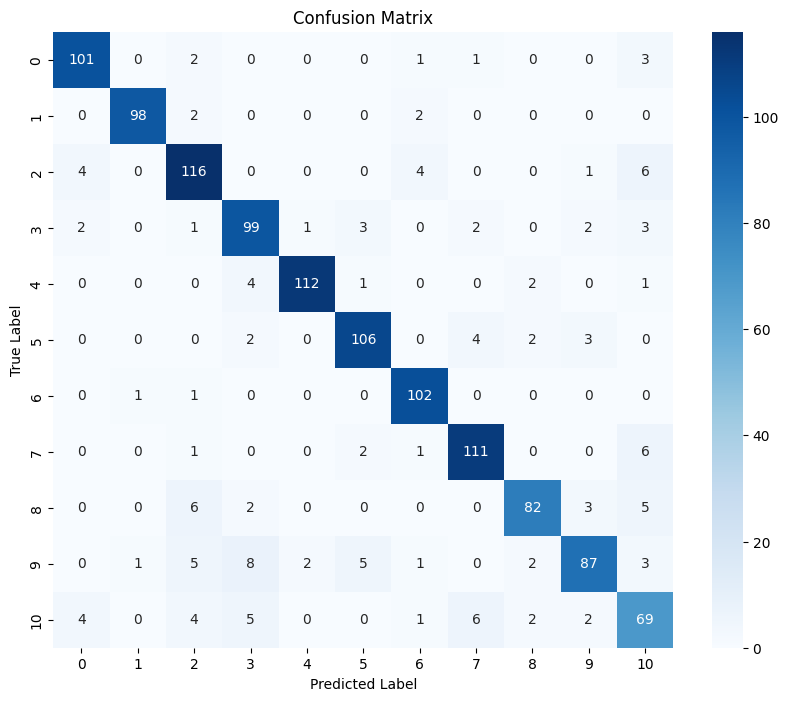

In [11]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
